In [0]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

fatal: destination path 'cocoapi' already exists and is not an empty directory.
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.l

In [1]:
cd/content/drive/My Drive/DocExplore Mask RCNN

/content/drive/My Drive/DocExplore Mask RCNN


we will be finetuning a pre-trained Mask R-CNN model in the DocExplore datebase for object detection and segmentation. It contains 90 images with ..... instances of objects. **texte en gras**

Defining the Dataset : 


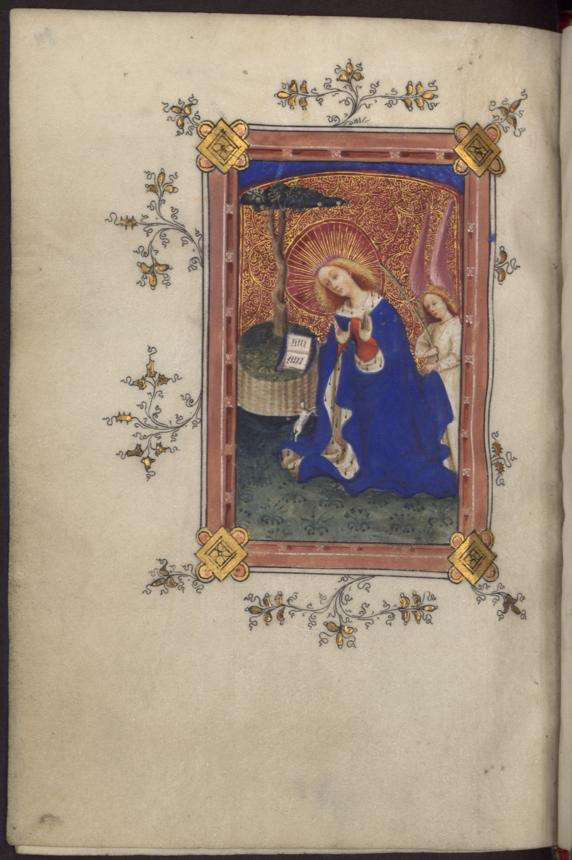

In [2]:
from PIL import Image
Image.open('DocExplore/PNGImages/page225.jpg')

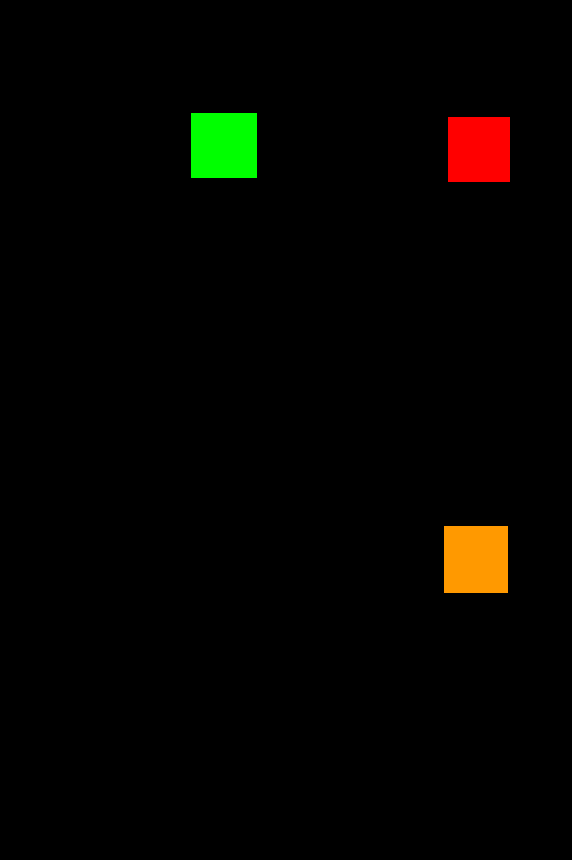

In [3]:
import numpy as np
mask = Image.open('DocExplore/PedMask/page225_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
colormap = np.ones((255, 3), dtype=float)
colormap[0] = [0, 0, 0]
mask.putpalette((colormap * 255).astype(np.uint8).flatten())
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    0, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [0]:
import os
import random
import time
import csv

import numpy as np

import torch
import torchvision

from PIL import Image
import cv2


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import display


from torch.autograd import Variable
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import transforms as T

from engine import train_one_epoch, evaluate
import utils



# from torchvision import transforms
# transform = transforms.Compose([transforms.ToTensor()])  # Convert image to PyTorch Tensor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

[[211, 557, 37, 25], [354, 526, 42, 25]]


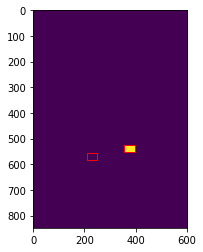

In [5]:
import numpy as np
from PIL import Image
import cv2
import csv
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import display

mask_path = 'DocExplore/PedMask/page700_mask.png'
box_csv = 'DocExplore/Bbox/page700.csv'
mask = Image.open(mask_path)
mask = np.array(mask)

plt.imshow(mask)
with open(box_csv, 'r') as f:
    reader = csv.reader(f)
    boxes = list(reader)
final_boxes = []
for box in boxes:
    x = int(box[0])
    y = int(box[1])
    width = int(box[2])
    height = int(box[3])
    if width == 0 or height == 0:
        continue
    else:
        final_boxes.append([x,y,width,height])
        plt.gca().add_patch(Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none'))
print(final_boxes) 
plt.show()


In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class DocExploreDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMask"))))
        self.boxes = list(sorted(os.listdir(os.path.join(root, "Bbox"))))
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages/", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMask/", self.masks[idx])
        box_path = os.path.join(self.root, "Bbox/", self.boxes[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        plt.imshow(mask)
       
        mask = np.array(mask)
       # print(mask.shape)
        with open(box_path, 'r') as f:
            reader = csv.reader(f)
            boxes = list(reader) 
            #print(boxes)   
        final_boxes = []
        for box in boxes:
            x = int(box[0])
            y = int(box[1])
            width = int(box[2])
            height = int(box[3])
            if x <= 0:
                x+=1
            if y <= 0:
                y+=1
            if x+width == 1280:
                x-=1
            if y+height == 720:
                y-=1    
            if width < 20 or height < 20:
                continue
            elif x + width > 1280 or y + height > 720:
                continue
            else:
                final_boxes.append([x,y,x+width,y+height])
        masks = np.zeros((len(final_boxes),720,1280))
       # print(masks.shape)
        for fb in range(len(final_boxes)):
           # print(fb)
            box = final_boxes[fb]
            xmin = box[0]
            xmax = box[2]
            ymin = box[1]
            ymax = box[3]
            #print(masks.shape)
            #print(mask.shape)
           
            masks[fb][ymin:ymax,xmin:xmax] = mask[ymin:ymax,xmin:xmax]
            
            masks[fb] = np.where(masks[fb] > 0, 1, 0)
                
        boxes = torch.as_tensor(final_boxes, dtype=torch.float32)
        labels = torch.ones((len(final_boxes),), dtype=torch.int64)
        image_id = torch.tensor([idx])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        iscrowd = torch.zeros((len(final_boxes),), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            try:
                img, target = self.transforms(img, target)
            except:
                print("problem at " + img_path)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
!ls maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [0]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
   
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [0]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [0]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [0]:
# our dataset has two classes only - background and hand
num_classes = 3
# use our dataset and defined transformations
dataset = DocExploreDataset('DocExplore', get_transform(train=True))
dataset_test = DocExploreDataset('DocExplore', get_transform(train=False))
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=1,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=collate_fn)

(tensor([[[0.1961, 0.1922, 0.1922,  ..., 0.1137, 0.1137, 0.1137],
          [0.1922, 0.1922, 0.1882,  ..., 0.1059, 0.1098, 0.1098],
          [0.1922, 0.1922, 0.1882,  ..., 0.1059, 0.1059, 0.1059],
          ...,
          [0.1765, 0.1804, 0.1804,  ..., 0.1608, 0.1608, 0.1608],
          [0.1765, 0.1804, 0.1804,  ..., 0.1608, 0.1608, 0.1608],
          [0.1765, 0.1765, 0.1804,  ..., 0.1608, 0.1608, 0.1608]],
 
         [[0.1529, 0.1490, 0.1490,  ..., 0.0824, 0.0784, 0.0784],
          [0.1490, 0.1490, 0.1451,  ..., 0.0706, 0.0745, 0.0745],
          [0.1490, 0.1490, 0.1451,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1294, 0.1294,  ..., 0.1020, 0.1020, 0.1020],
          [0.1255, 0.1294, 0.1294,  ..., 0.1020, 0.1020, 0.1020],
          [0.1255, 0.1255, 0.1294,  ..., 0.1020, 0.1020, 0.1020]],
 
         [[0.1765, 0.1725, 0.1725,  ..., 0.0745, 0.0824, 0.0824],
          [0.1725, 0.1725, 0.1686,  ..., 0.0745, 0.0784, 0.0863],
          [0.1725, 0.1725, 0.1686,  ...,

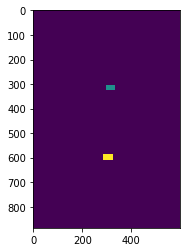

In [11]:
dataset[0]

In [0]:
# Helper functions to draw predictions:

import torchvision.transforms as T
def plot_mask_rcnn_result(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask  


def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img.to(device)])
    #print(pred)
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    #print(pred_score)
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [i for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]  
    return masks, pred_boxes, pred_class      

In [0]:
cd /content/drive/My Drive/DocExplore Mask RCNN


/content/drive/My Drive/DocExplore Mask RCNN


In [0]:
!ls maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth

maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [0]:
cd

/root


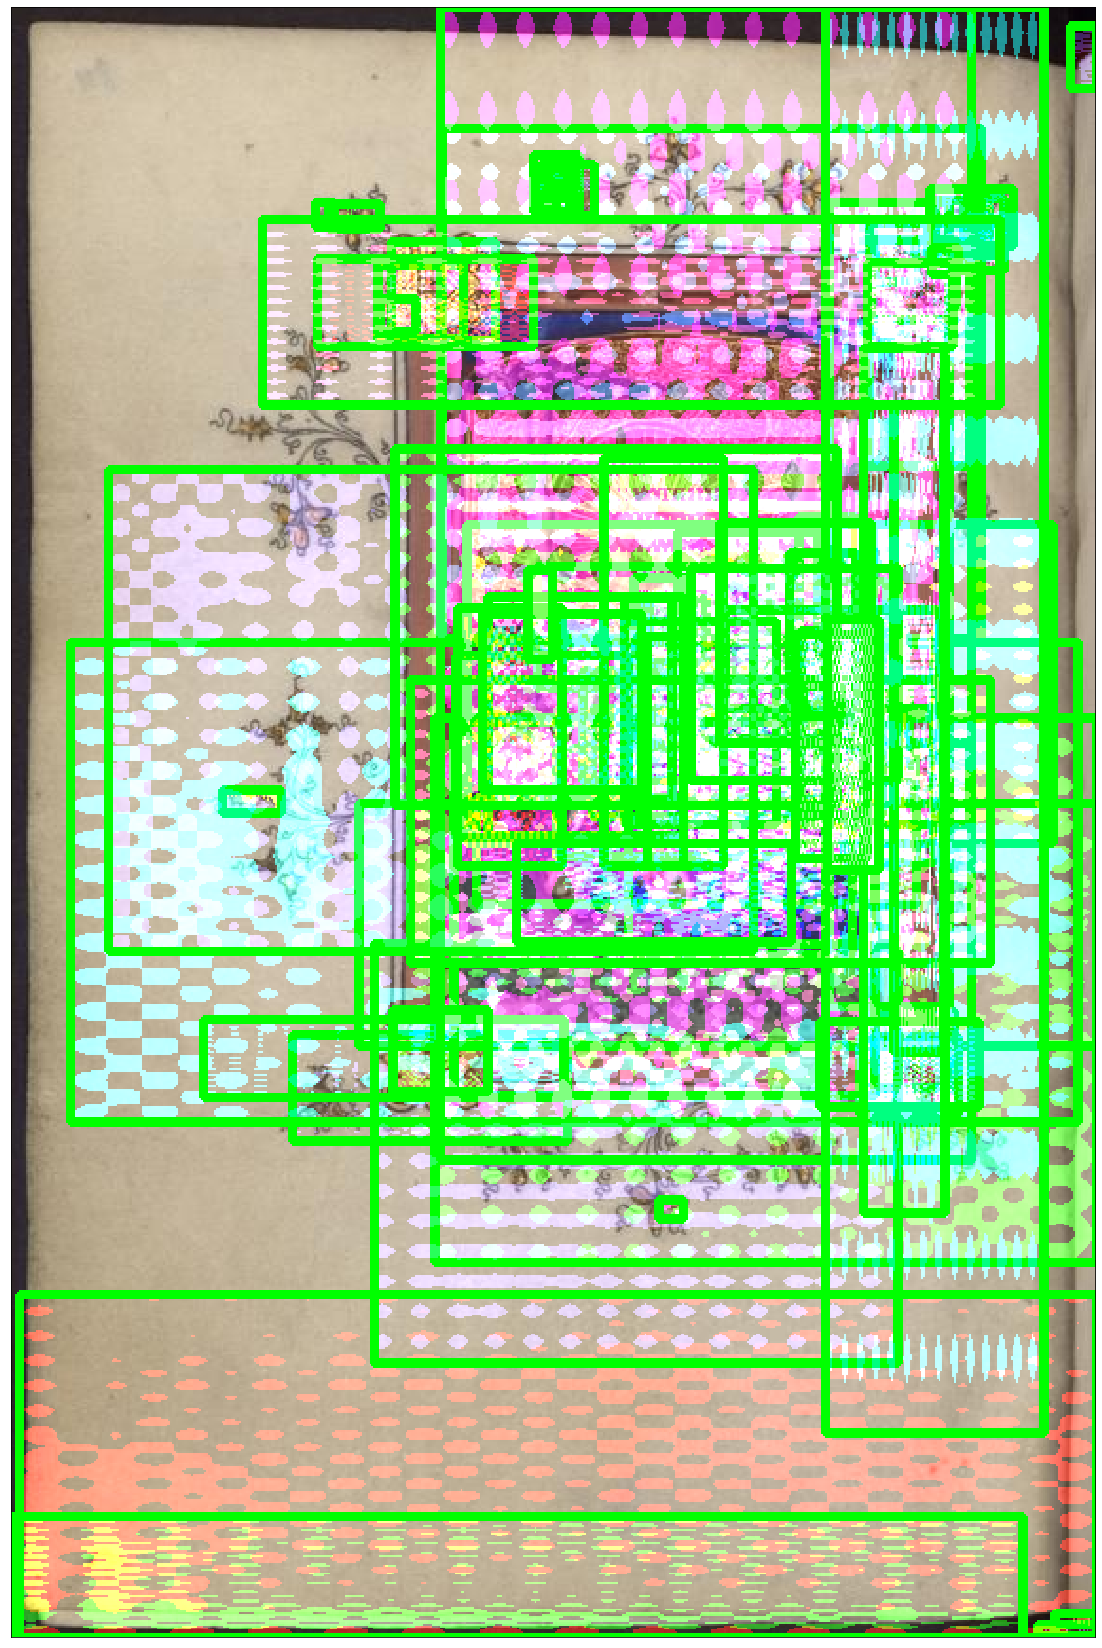

In [15]:

model = get_model_instance_segmentation(num_classes)
model.to(device)
model.eval()
plot_mask_rcnn_result('DocExplore/PNGImages/page225.jpg', threshold=0.09)

In [16]:
model = get_model_instance_segmentation(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.005)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6, 9], gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

num_epochs = 20
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    optimizer.step()
    lr_scheduler.step()

Epoch: [0]  [ 0/20]  eta: 0:02:18  lr: 0.000268  loss: 3.1290 (3.1290)  loss_classifier: 0.9667 (0.9667)  loss_box_reg: 0.0251 (0.0251)  loss_mask: 1.6842 (1.6842)  loss_objectness: 0.4104 (0.4104)  loss_rpn_box_reg: 0.0425 (0.0425)  time: 6.9175  data: 2.5413  max mem: 2262
some issue here. skipping.
Epoch: [1]  [ 0/20]  eta: 0:01:35  lr: 0.000268  loss: 2.6614 (2.6614)  loss_classifier: 0.2462 (0.2462)  loss_box_reg: 0.1419 (0.1419)  loss_mask: 1.5690 (1.5690)  loss_objectness: 0.6782 (0.6782)  loss_rpn_box_reg: 0.0261 (0.0261)  time: 4.7821  data: 0.1837  max mem: 2814
some issue here. skipping.
Epoch: [2]  [ 0/20]  eta: 0:01:38  lr: 0.000268  loss: 1.0925 (1.0925)  loss_classifier: 0.3368 (0.3368)  loss_box_reg: 0.1483 (0.1483)  loss_mask: 0.2636 (0.2636)  loss_objectness: 0.3211 (0.3211)  loss_rpn_box_reg: 0.0226 (0.0226)  time: 4.9317  data: 1.4087  max mem: 2871
some issue here. skipping.
some issue here. skipping.
Epoch: [4]  [ 0/20]  eta: 0:01:33  lr: 0.000027  loss: 8.1162 (8

In [0]:
num_classes=3
state_dict = torch.load('finetuned_19.pth')
model.load_state_dict(state_dict)
# move model to the right device
model.to(device)
model.eval();

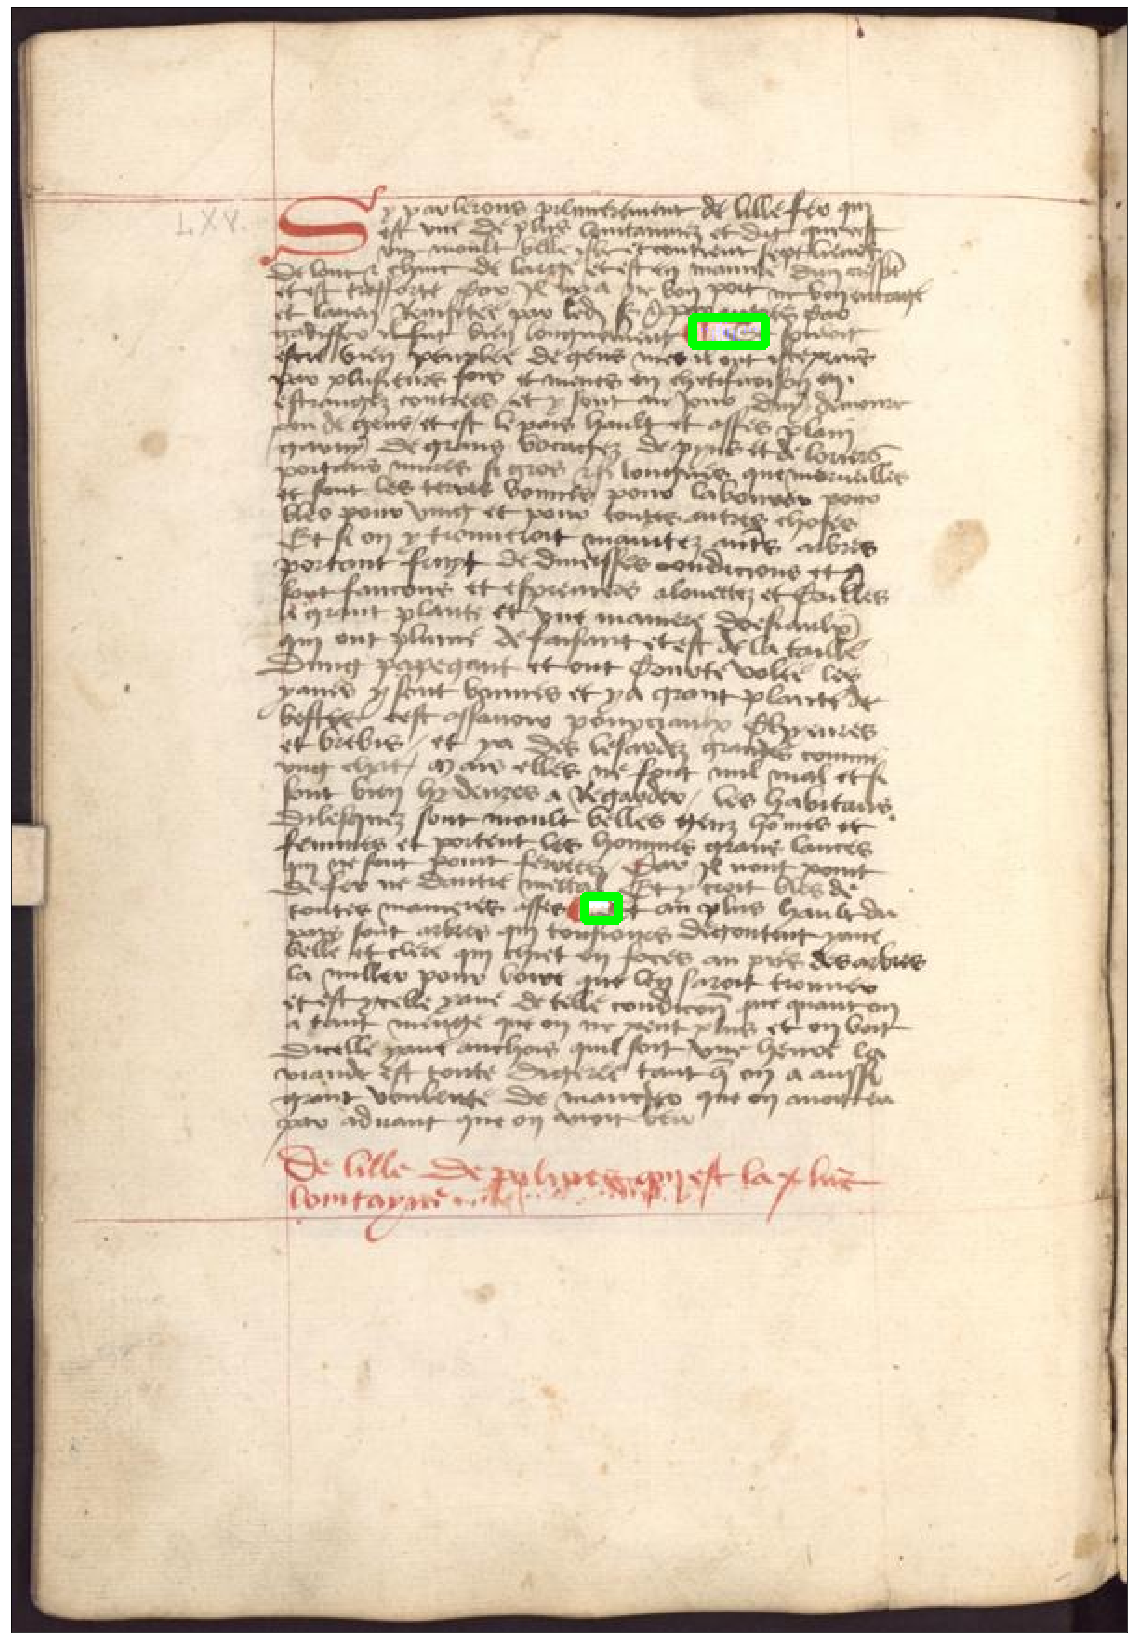

In [57]:
plot_mask_rcnn_result('DocExplore/PNGImages/page688.jpg', threshold=0.45)